# Assignment 8: Ensemble Regression

# Part A: Data Processing and Baseline

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

In [2]:
random_state = 24

## Data Loading and Feature Engineering

In [3]:
df = pd.read_csv('datasets/hour.csv')

# Display initial data overview (visualization: head and summary)
print("Initial Data Shape:", df.shape)
display(df.head())  # In notebook, shows table
print("\nData Summary:")
display(df.describe())

Initial Data Shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



Data Summary:


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


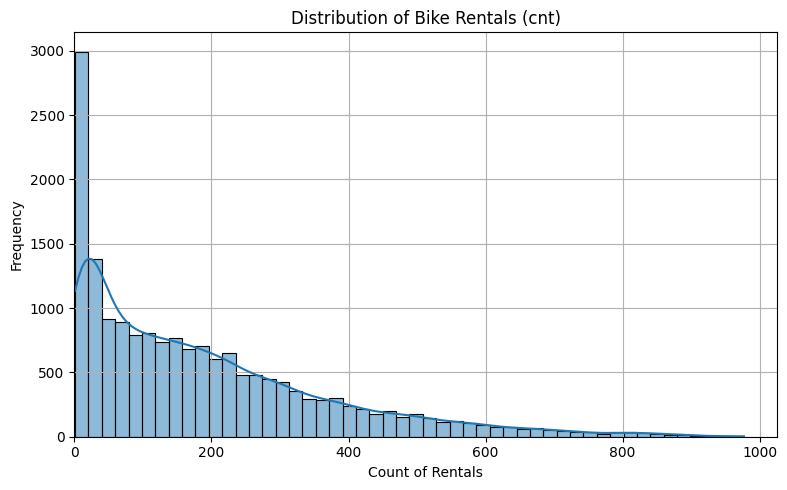

In [4]:
# Visualization: Distribution of target variable 'cnt'
plt.figure(figsize=(8, 5))
sns.histplot(df['cnt'], bins=50, kde=True)
plt.title('Distribution of Bike Rentals (cnt)')
plt.xlabel('Count of Rentals')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.xlim(0)
plt.show()

Looks like the data is very left skewed. This isn't necessarily a very strong class imbalance. A log scale for the target variable `cnt` might help normalise the data

In [5]:
# Drop irrelevant columns
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Identify categorical features for one-hot encoding
categorical_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

# Apply one-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_data = df[categorical_features]
encoded_cats = encoder.fit_transform(categorical_data)
encoded_df = pd.DataFrame(encoded_cats, 
                          columns=encoder.get_feature_names_out(categorical_features), 
                          index=df.index)
df = pd.concat([df.drop(categorical_features, axis=1), encoded_df], axis=1)

# Separate features (X) and target (y)
X = df.drop('cnt', axis=1)
y = df['cnt']

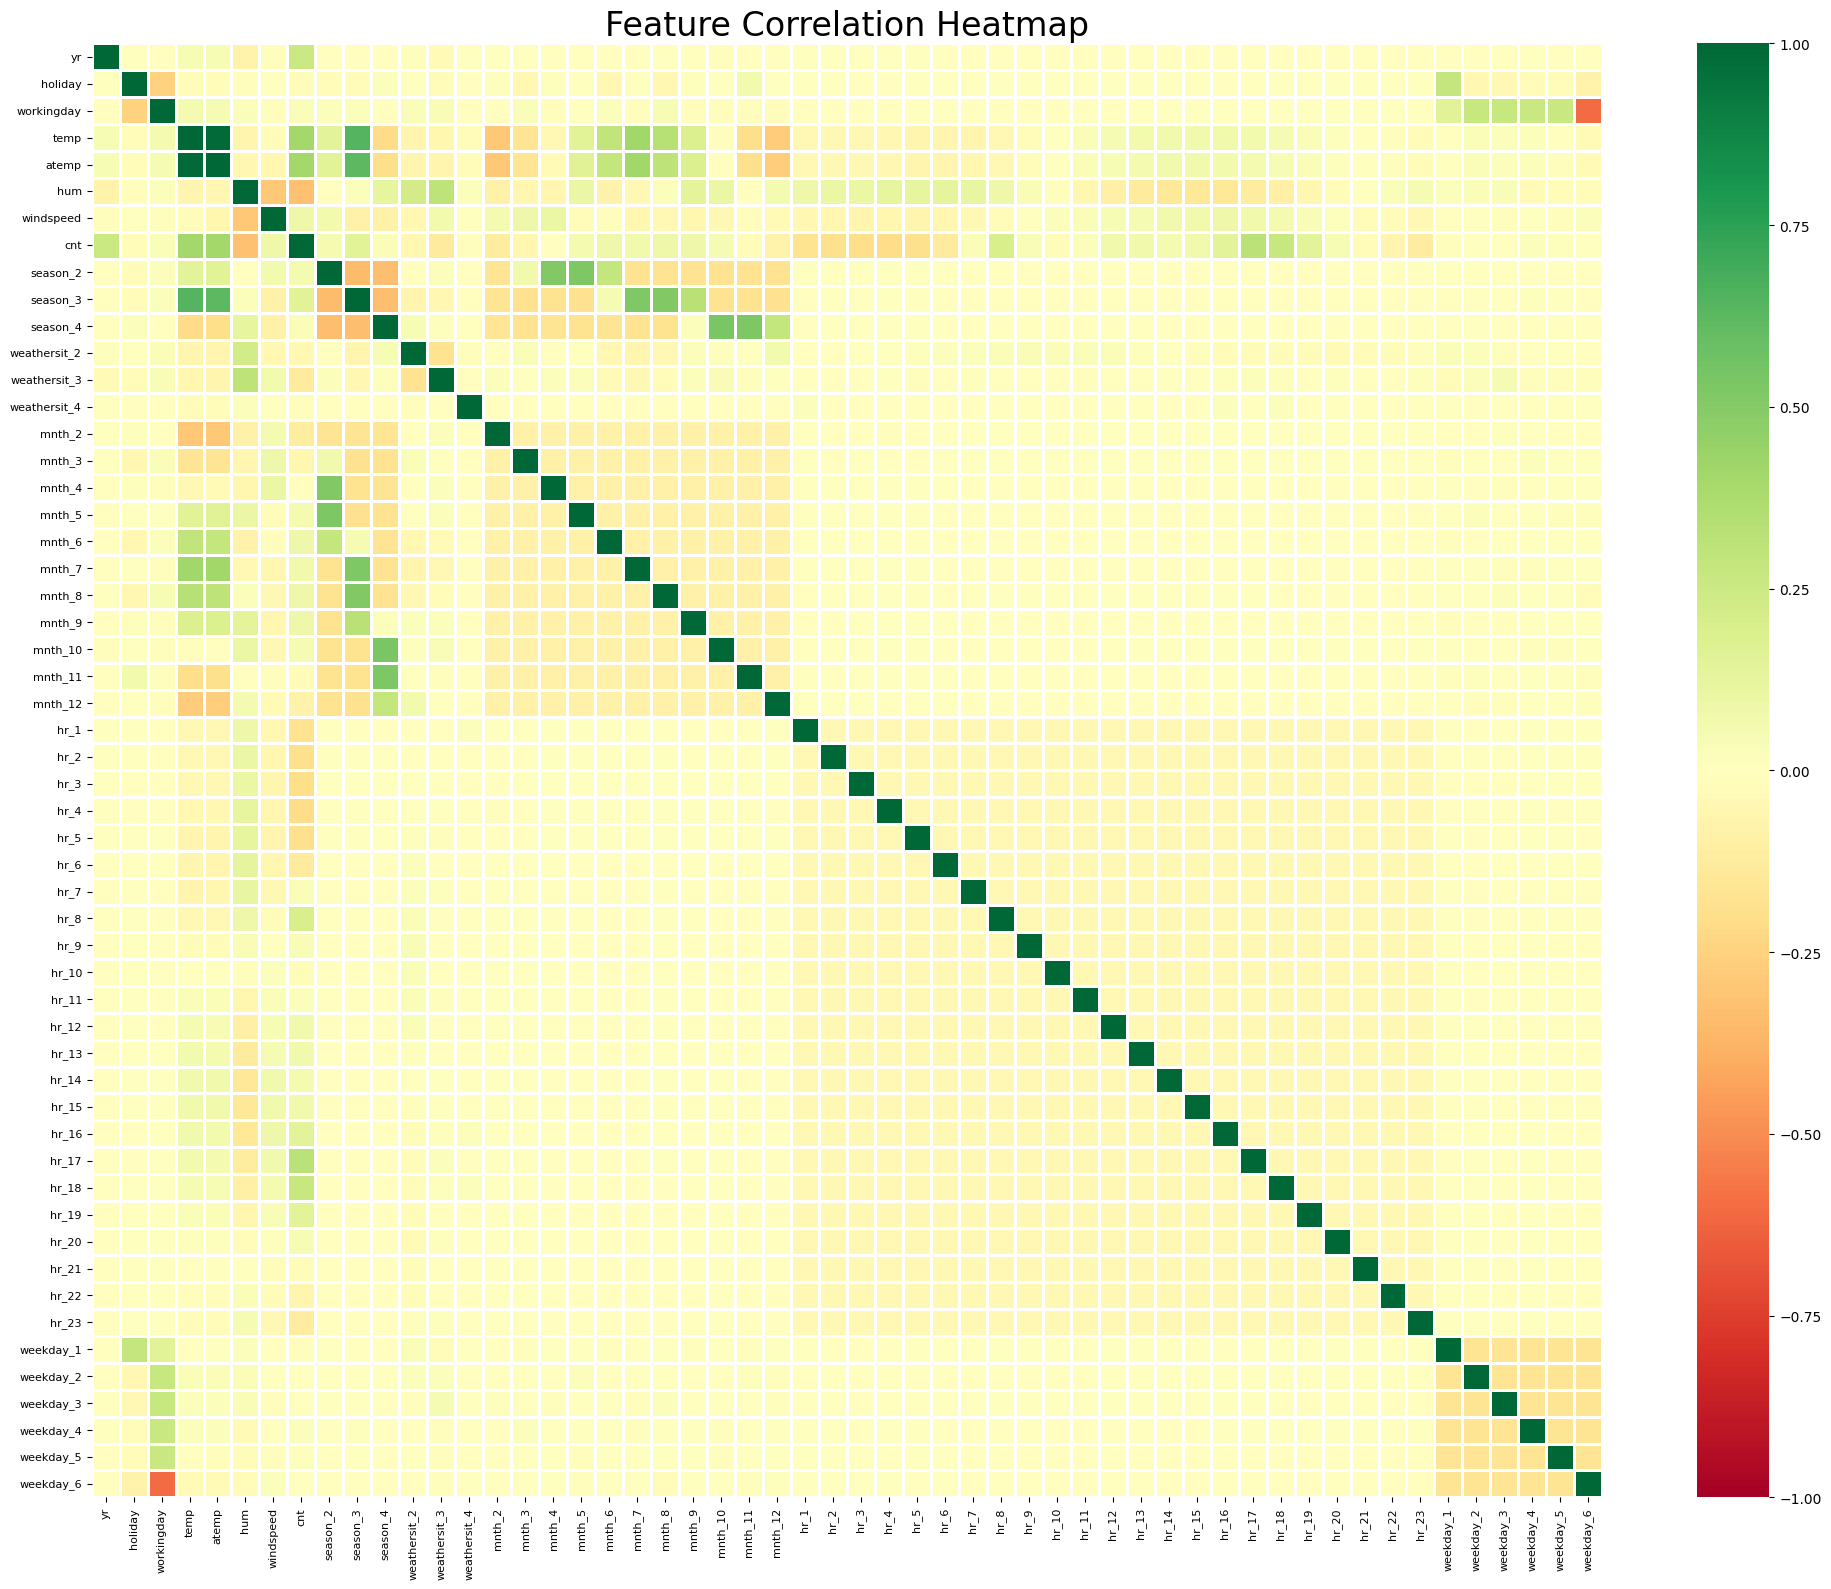

In [6]:
# Visualization
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, linewidths=1,
            cmap='RdYlGn', vmin=-1, vmax=1, xticklabels=1, yticklabels=1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Feature Correlation Heatmap', fontsize=24)
plt.tight_layout()
plt.show()

This image highlights the correlations between different features. As expected:
1. There is non-zero correlation between one-hot encoded features
2. There is some correlation between the month and some weather parameters like `temp` and `humidity`. Which makes sense
3. Our target `cnt` has non-zero correlation with quite a few features indicating that there is good amount of signal among the noise

## Train/Test Split

In [7]:
# Split data (no shuffle for time-series integrity)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=random_state)

print("Train Shape:", X_train.shape, "\nTest Shape:", X_test.shape)

Train Shape: (13903, 53) 
Test Shape: (3476, 53)


## Baseline Model

The baseline models required are:
1. Decision Tree Regressor (*max_depth = 6*)
2. Linear Regression

These models don't have a lot of hyperparameters to tune, nevertheless we will try to get the best models possible.

Notably for this entire experiment, we cannot use regular cross validation since the data is a time series. This is because regular cross validation does not take into account the relationship between datapoints (time). We, therefore, must use sklearn's inbuilt functionality of TimeSeriesSplit.

In [8]:
# Define TimeSeriesSplit for CV (5 splits, suitable for time-series)
tscv = TimeSeriesSplit(n_splits=5)

# Optimize Decision Tree: GridSearchCV for max_depth
dt_param_grid = {'max_depth': [6], 'min_samples_split': [2, 10, 20]}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=random_state),
                       dt_param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Best DT params and CV RMSE (negative score to positive)
best_dt = dt_grid.best_estimator_
best_min_samp_split = dt_grid.best_params_['min_samples_split']
dt_cv_rmse = -dt_grid.best_score_
print(f"Optimized Decision Tree min_samples_split: {best_min_samp_split}")
print(f"Decision Tree CV RMSE: {dt_cv_rmse:.4f}")

# Refit best DT on full train and evaluate on test
best_dt.fit(X_train, y_train)
dt_preds = best_dt.predict(X_test)
dt_test_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
print(f"Optimized Decision Tree Test RMSE: {dt_test_rmse:.4f}")

Optimized Decision Tree min_samples_split: 2
Decision Tree CV RMSE: 135.0535
Optimized Decision Tree Test RMSE: 159.1348


In [9]:
# For Linear Regression
lr = LinearRegression()
lr_cv_scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lr.fit(X_tr, y_tr)
    preds = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    lr_cv_scores.append(rmse)
lr_cv_rmse = np.mean(lr_cv_scores)
print(f"Linear Regression CV RMSE: {lr_cv_rmse:.4f}")

# Fit LR on full train and evaluate on test
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
print(f"Linear Regression Test RMSE: {lr_test_rmse:.4f}")

# Select the better optimized baseline
baseline_rmse = min(dt_test_rmse, lr_test_rmse)
baseline_model = "Optimized Decision Tree" if dt_test_rmse < lr_test_rmse else "Linear Regression"
print(f"Optimized Baseline Model: {baseline_model} with Test RMSE {baseline_rmse:.4f}")

Linear Regression CV RMSE: 112.6817
Linear Regression Test RMSE: 133.8354
Optimized Baseline Model: Linear Regression with Test RMSE 133.8354


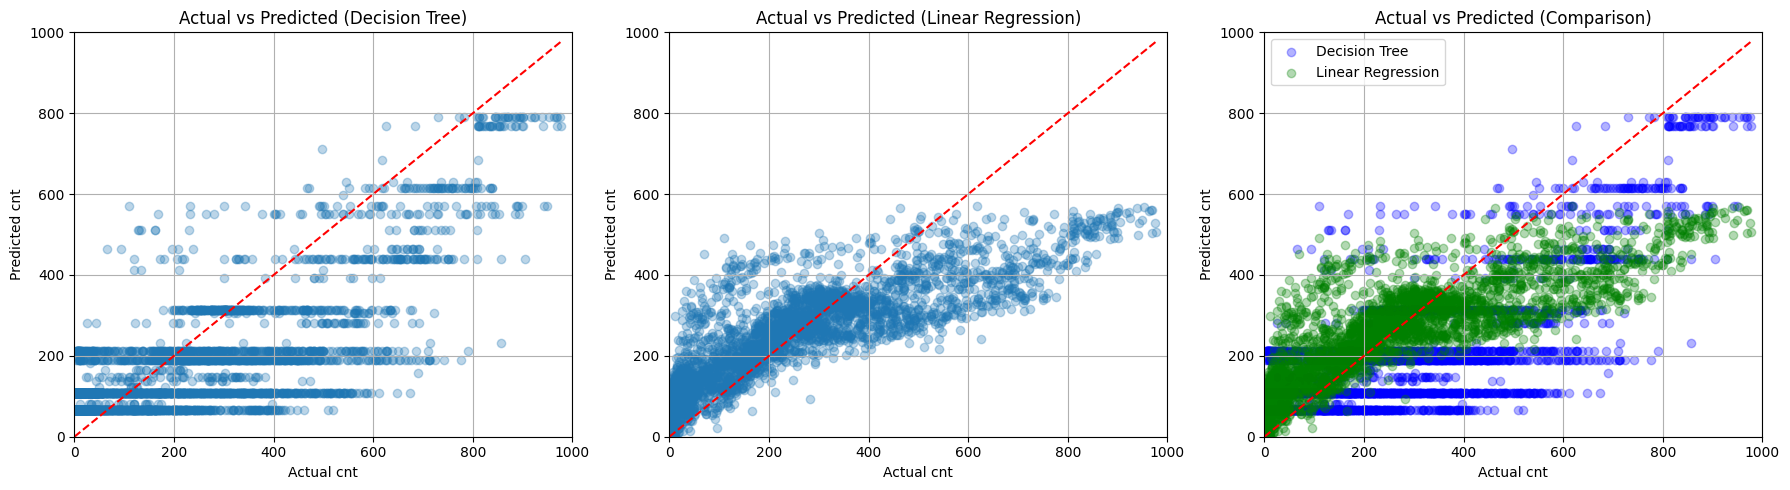

In [20]:
# Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for Decision Tree
axs[0].scatter(y_test, dt_preds, alpha=0.3)
axs[0].plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
axs[0].set_title(f'Actual vs Predicted (Decision Tree)')
axs[0].set_xlabel('Actual cnt')
axs[0].set_ylabel('Predicted cnt')
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1000)
axs[0].grid()

# Plot for LR
axs[1].scatter(y_test, lr_preds, alpha=0.3)
axs[1].plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
axs[1].set_title('Actual vs Predicted (Linear Regression)')
axs[1].set_xlabel('Actual cnt')
axs[1].set_ylabel('Predicted cnt')
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 1000)
axs[1].grid()

# Combined comparison (overlay predictions)
axs[2].scatter(y_test, dt_preds, alpha=0.3, label='Decision Tree', color='blue')
axs[2].scatter(y_test, lr_preds, alpha=0.3, label='Linear Regression', color='green')
axs[2].plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
axs[2].set_title('Actual vs Predicted (Comparison)')
axs[2].set_xlabel('Actual cnt')
axs[2].set_ylabel('Predicted cnt')
axs[2].set_xlim(0, 1000)
axs[2].set_ylim(0, 1000)
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()

These graphs are made to show how well the model predicts the data and where it fails. The red dotted line represents the line `y = x`. Since the x-axis of these plots represent the actual values and the y-axis represent the predicted values, ideally, our model should be able to bring all the points on this line. This is because if our model is perfect, it will predict the predicted value to be exactly equal to the actual value therefore, plotting it on the red line.

The baseline results are outlined below:

    Linear Regression test RMSE: 133.8354

    Decision Trees test RMSE: 159.1348

So clearly, Linear Regression is the more superior baseline model since it performs better on the test set.

# Part B: Ensemble Techniques for Bias and Variance Reduction

## Bagging (Variance Reduction)

In [21]:
# Hypothesis: Bagging primarily targets variance reduction
# Define TimeSeriesSplit for CV (5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Optimize Bagging: GridSearchCV for n_estimators
bagging_param_grid = {'n_estimators': [50, 100, 250, 500, 650, 750, 1000]}
bagging_grid = GridSearchCV(BaggingRegressor(estimator=best_dt,  # Optimized baseline DT
                                             random_state=random_state, 
                                             n_jobs=-1), 
                            bagging_param_grid, 
                            cv=tscv, 
                            scoring='neg_root_mean_squared_error', 
                            n_jobs=-1)
bagging_grid.fit(X_train, y_train)

# Best params and CV RMSE (negative score to positive)
best_bagging = bagging_grid.best_estimator_
best_n_estimators = bagging_grid.best_params_['n_estimators']
bagging_cv_rmse = -bagging_grid.best_score_
print(f"Optimized Bagging n_estimators: {best_n_estimators}")
print(f"Bagging CV RMSE: {bagging_cv_rmse:.4f}")

# Refit best Bagging on full train and evaluate on test
best_bagging.fit(X_train, y_train)
bagging_preds = best_bagging.predict(X_test)
bagging_rmse = np.sqrt(mean_squared_error(y_test, bagging_preds))
print(f"Optimized Bagging Regressor Test RMSE: {bagging_rmse:.4f}")

# Checking if variance reduced vs single DT baseline
base_dt_preds = best_dt.predict(X_test)
base_dt_rmse = np.sqrt(mean_squared_error(y_test, base_dt_preds))
print(f"Baseline Decision Tree Regressor RMSE: {base_dt_rmse:.4f}")
base_lr_preds = lr.predict(X_test)
base_lr_rmse = np.sqrt(mean_squared_error(y_test, base_lr_preds))
print(f"Baseline Linear Regression Test RMSE: {base_lr_rmse:.4f}")

Optimized Bagging n_estimators: 500
Bagging CV RMSE: 125.8268
Optimized Bagging Regressor Test RMSE: 155.7432
Baseline Decision Tree Regressor RMSE: 159.1348
Baseline Linear Regression Test RMSE: 133.8354


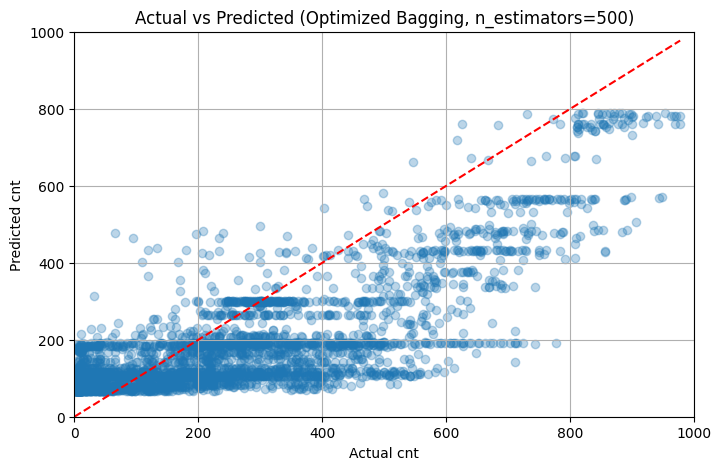

In [22]:
# Visualization: Actual vs Predicted for Optimized Bagging
plt.figure(figsize=(8, 5))
plt.scatter(y_test, bagging_preds, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.title(f'Actual vs Predicted (Optimized Bagging, n_estimators={best_n_estimators})')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.grid()
plt.show()

The best Bagging model with 500 estimators seems to perform **slightly better** than the baseline Linear regression model. The RMSE scores on test set further solidify our observations:

`Bagging Test RMSE of 125.8268` is not vastly better than Linear regression's ~ 133.8

### Discuss whether the bagging technique effectively reduced variance compared to the single Decision Tree baseline.

## Boosting (Bias Reduction)

In [23]:
# Hypothesis: Boosting primarily targets bias reduction
# Define param grid for Gradient Boosting (balanced for computation)
gb_param_grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.3, 0.4, 0.5]
}

# GridSearchCV (using TimeSeriesSplit from earlier)
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=random_state), 
                       gb_param_grid, 
                       cv=tscv, 
                       scoring='neg_root_mean_squared_error', 
                       n_jobs=-1, 
                       verbose=1)
gb_grid.fit(X_train, y_train)

# Best params and CV RMSE (negative score to positive)
best_gb = gb_grid.best_estimator_
best_gb_params = gb_grid.best_params_
gb_cv_rmse = -gb_grid.best_score_
print(f"Optimized Gradient Boosting Params: {best_gb_params}")
print(f"Gradient Boosting CV RMSE: {gb_cv_rmse:.4f}")

# Refit best GB on full train and evaluate on test
best_gb.fit(X_train, y_train)
gb_preds = best_gb.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
print(f"Optimized Gradient Boosting Regressor Test RMSE: {gb_rmse:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Optimized Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.4}
Gradient Boosting CV RMSE: 77.3902
Optimized Gradient Boosting Regressor Test RMSE: 72.9988


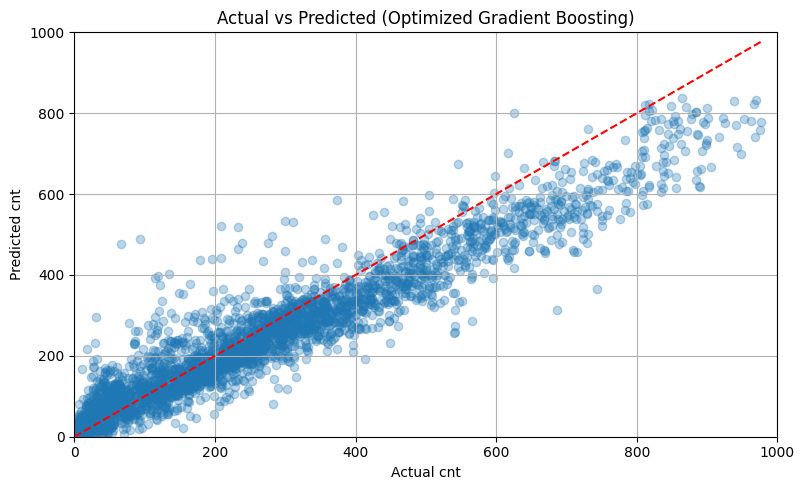

In [24]:
# Visualization: Actual vs Predicted for Optimized Boosting
plt.figure(figsize=(8, 5))
plt.scatter(y_test, gb_preds, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted (Optimized Gradient Boosting)')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt')
plt.tight_layout()
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.grid()
plt.show()

The best Boosting model with 

- learning_rate = 0.1
- max_depth = 3, 
- n_estimators = 2000, 
- subsample = 0.4

seems to perform **significantly better** than all previous models. The RMSE scores on test set further solidify our observations:

`Boosting Test RMSE of 72.9988` is vastly better than Linear regression's ~ 133.8 and Bagging's ~ 125.8



### Discuss whether boosting achieved a better result than both the single model and the bagging ensemble, supporting the idea of bias reduction.


# Part C: Stacking for Optimal Performance

Base Learners (Level-0):
- K-Nearest Neighbors Regressor (KNeighborsRegressor)
- Bagging Regressor (from Part B)
- Gradient Boosting Regressor (from Part B)


Meta-Learner (Level-1): 
- Ridge Regression model.


## Stacking Implementation



### Best KNN model

We must first find the optimal KNN model for our dataset. This requires that we use time series cross validation.

In [26]:
# Optimize KNN separately before stacking
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_grid = GridSearchCV(KNeighborsRegressor(), 
                        knn_param_grid, 
                        cv=tscv, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1, 
                        verbose=1)
knn_grid.fit(X_train, y_train)

# Best params and CV RMSE
best_knn = knn_grid.best_estimator_
best_knn_params = knn_grid.best_params_
knn_cv_rmse = -knn_grid.best_score_
print(f"Optimized KNN Params: {best_knn_params}")
print(f"KNN CV RMSE: {knn_cv_rmse:.4f}")

# Evaluate standalone on test for reference
best_knn.fit(X_train, y_train)
knn_preds = best_knn.predict(X_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
print(f"Optimized KNN Test RMSE: {knn_rmse:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Optimized KNN Params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN CV RMSE: 120.4724
Optimized KNN Test RMSE: 138.9348


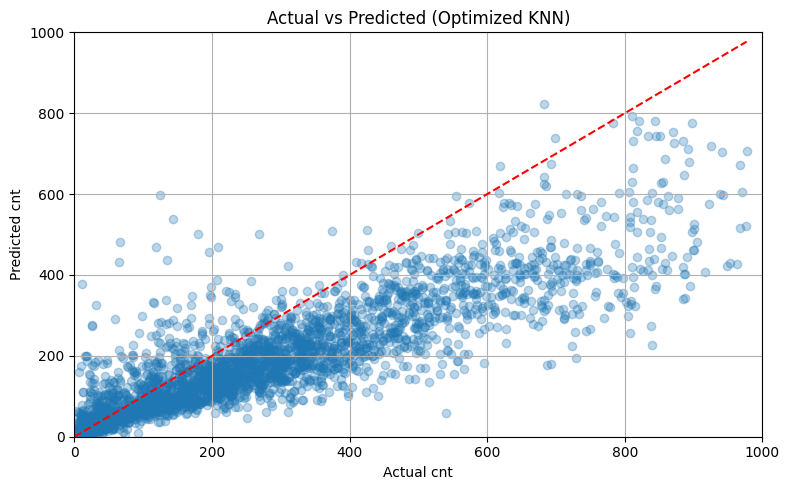

In [27]:
# Visualization: Actual vs Predicted for Optimized KNN
plt.figure(figsize=(8, 5))
plt.scatter(y_test, knn_preds, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted (Optimized KNN)')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt')
plt.grid()
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()

KNN performs slightly worse than our baseline (Linear regression ~ 133.8). With a `KNN Test RMSE of 138.9348`, this model by itself is not very good.

### Best Ridge model

We must also find the best hyperparameters for out level-1 model: Ridge regressor. The cross validation process for this is not straight-forward since we need to optimise the ridge with the entire stack. So the idea is to create a X_meta_train and X_meta_test dataset that is essentially the output of level-0 on the train and test data respectively.

In [33]:
# Define base learners (using optimized ones)
base_learners_for_meta = [
    ('knn', best_knn),
    ('bagging', best_bagging),
    ('boosting', best_gb)
]

# Manual out-of-fold meta-features on train
n_bases = len(base_learners_for_meta)
X_meta_train = np.zeros((len(X_train), n_bases))

for i, (name, est) in enumerate(base_learners_for_meta):
    oof_preds = np.zeros(len(X_train))
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        est_clone = clone(est)
        est_clone.fit(X_tr, y_tr)
        oof_preds[val_idx] = est_clone.predict(X_val)
    X_meta_train[:, i] = oof_preds

# Generate meta-features on test (fit on full train)
X_meta_test = np.zeros((len(X_test), n_bases))
for i, (name, est) in enumerate(base_learners_for_meta):
    est.fit(X_train, y_train)  # Refit on full train
    X_meta_test[:, i] = est.predict(X_test)

# Optimize Ridge on meta-features
ridge_param_grid = {'alpha': [1e-2, 1e-1, 1, 5 ]}

ridge_grid = GridSearchCV(Ridge(), 
                          ridge_param_grid, 
                          cv=tscv, 
                          scoring='neg_root_mean_squared_error', 
                          n_jobs=-1, 
                          verbose=1)
ridge_grid.fit(X_meta_train, y_train)

# Best params and CV RMSE
best_ridge = ridge_grid.best_estimator_
best_ridge_params = ridge_grid.best_params_
ridge_cv_rmse = -ridge_grid.best_score_
print(f"Optimized Ridge Params: {best_ridge_params}")
print(f"Ridge CV RMSE on Meta-Features: {ridge_cv_rmse:.4f}")

# Use best_ridge as meta_learner in stacking code
meta_learner = best_ridge

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Optimized Ridge Params: {'alpha': 0.01}
Ridge CV RMSE on Meta-Features: 109.3411


## Final Implementation

In [34]:
# Define Base Learners (Level-0) with optimized models
base_learners = [
    ('knn', best_knn),
    ('bagging', best_bagging),
    ('boosting', best_gb)
]

# Define Meta-Learner (Level-1) with optimized Ridge
meta_learner = best_ridge

# Manual Stacking for time-series
n_bases = len(base_learners)
X_meta_train = np.zeros((len(X_train), n_bases))
for i, (name, est) in enumerate(base_learners):
    oof_preds = np.zeros(len(X_train))
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        est_clone = clone(est)
        est_clone.fit(X_tr, y_tr)
        oof_preds[val_idx] = est_clone.predict(X_val)
    X_meta_train[:, i] = oof_preds

X_meta_test = np.zeros((len(X_test), n_bases))
for i, (name, est) in enumerate(base_learners):
    est.fit(X_train, y_train)
    X_meta_test[:, i] = est.predict(X_test)

meta_learner.fit(X_meta_train, y_train)
stacking_preds = meta_learner.predict(X_meta_test)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))
print(f"Optimized Stacking Regressor Test RMSE: {stacking_rmse:.4f}")

Optimized Stacking Regressor Test RMSE: 71.8284


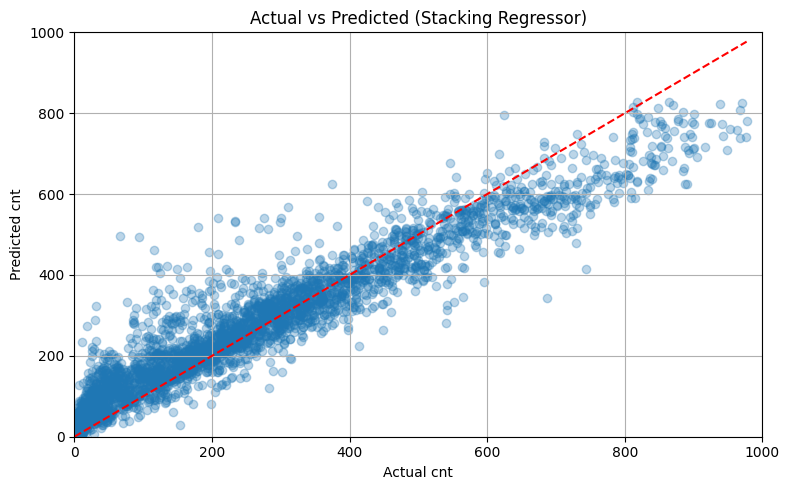

In [35]:
# Visualization: Actual vs Predicted for Stacking
plt.figure(figsize=(8, 5))
plt.scatter(y_test, stacking_preds, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted (Stacking Regressor)')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.grid()
plt.tight_layout()
plt.show()

The best Stacked Regression model seems to perform **significantly better** than all previous models. The RMSE scores on test set further solidify our observations:

`Stacking Regressor Test RMSE of 71.8284` is vastly better than Linear regression's ~ 133.8 and Bagging's ~ 125.8. Notably it also edges out the Boosting model (RMSE~73). Let's discuss this in the last section

# Part D: Final Analysis

## Comparative Table

In [39]:
# Part D.1: Comparative Table
# Create DataFrame for RMSE summary (include both singles for "five models"; mark baseline)
models = [
    'Linear Regression',
    'Decision Tree Regressor',
    'Bagging Regressor',
    'Gradient Boosting Regressor',
    'Stacking Regressor'
]
rmses = [lr_test_rmse, dt_test_rmse, bagging_rmse, gb_rmse, stacking_rmse]

df_summary = pd.DataFrame({
    'Model': models,
    'Test_RMSE': [f"{rmse:.4f}" for rmse in rmses],
})

# Display table
print("Comparative RMSE Table:")
display(df_summary)  # In Jupyter, shows styled table

# Part D.2: Conclusion (add in markdown, but print for code)
best_model = df_summary.loc[df_summary['Test_RMSE'].astype(float).idxmin(), 'Model']
print(f"\nBest-Performing Model: {best_model}")

Comparative RMSE Table:


,Model,Test_RMSE
0,Linear Regression,133.8354
1,Decision Tree Regressor,159.1348
2,Bagging Regressor,155.7432
3,Gradient Boosting Regressor,72.9988
4,Stacking Regressor,71.8284



Best-Performing Model: Stacking Regressor


## Conclusion